In [1]:
!pip install quantecon

In [2]:
import numpy as np

from numba import jit, float64, int64
from numba.experimental import jitclass
from quantecon.distributions import BetaBinomial

import matplotlib.pyplot as plt

np.random.seed(123)

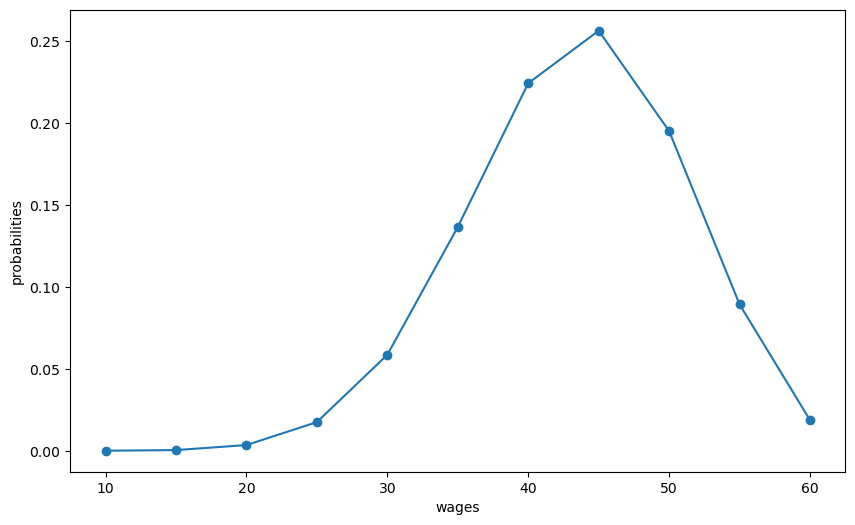

In [3]:
n, a, b = 10, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

# plot distribution of wage offer
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

In [4]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:]),    # array of probabilities
]


@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w, q

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

    def VFI(self, eps=1e-5, max_iter=500):
        """
        Find the optimal value function.
        """

        n = len(self.w)
        v = self.w / (1 - self.β)
        v_next = np.empty_like(v)
        flag=0

        for i in range(max_iter):
            for j in range(n):
                v_next[j] = np.max(self.state_action_values(j, v))

            if np.max(np.abs(v_next - v))<=eps:
                flag=1
                break
            v[:] = v_next

        return v, flag

def plot_value_function_seq(mcm, ax, num_plots=8):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

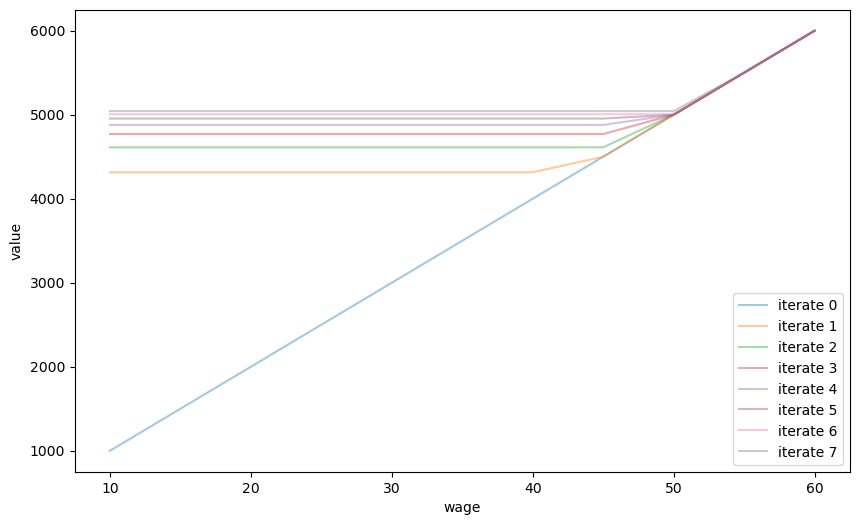

In [5]:
mcm = McCallModel()
valfunc_VFI, flag = mcm.VFI()

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

In [6]:
print(valfunc_VFI)

[5322.27935875 5322.27935875 5322.27935875 5322.27935875 5322.27935875
 5322.27935875 5322.27935875 5322.27935875 5322.27935875 5500.
 6000.        ]


In [7]:
params=[
    ('c', float64),            # unemployment compensation
    ('β', float64),            # discount factor
    ('w', float64[:]),         # array of wage values, w[i] = wage at state i
    ('q', float64[:]),         # array of probabilities
    ('eps', float64),          # for epsilon greedy algorithm
    ('δ', float64),            # Q-table threshold
    ('lr', float64),           # the learning rate α
    ('T', int64),              # maximum periods of accepting
    ('quit_allowed', int64)    # whether quit is allowed after accepting the wage offer
]

@jitclass(params)
class Qlearning_McCall:
    def __init__(self, c=25, β=0.99, w=w_default, q=q_default, eps=0.1,
                 δ=1e-5, lr=0.5, T=10000, quit_allowed=0):

        self.c, self.β = c, β
        self.w, self.q = w, q
        self.eps, self.δ, self.lr, self.T = eps, δ, lr, T
        self.quit_allowed = quit_allowed


    def draw_offer_index(self):
        """
        Draw a state index from the wage distribution.
        """

        q = self.q
        return np.searchsorted(np.cumsum(q), np.random.random(), side="right")

    def temp_diff(self, qtable, state, accept):
        """
        Compute the TD associated with state and action.
        """

        c, β, w = self.c, self.β, self.w

        if accept==0:
            state_next = self.draw_offer_index()
            TD = c + β*np.max(qtable[state_next, :]) - qtable[state, accept]
        else:
            state_next = state
            if self.quit_allowed == 0:
                TD = w[state_next] + β*np.max(qtable[state_next, :]) - qtable[state, accept]
            else:
                TD = w[state_next] + β*qtable[state_next, 1] - qtable[state, accept]

        return TD, state_next

    def run_one_epoch(self, qtable, max_times=20000):
        """
        Run an "epoch".
        """

        c, β, w = self.c, self.β, self.w
        eps, δ, lr, T = self.eps, self.δ, self.lr, self.T

        s0 = self.draw_offer_index()
        s = s0
        accept_count = 0

        for t in range(max_times):

            # choose action
            accept = np.argmax(qtable[s, :])
            if np.random.random()<=eps:
                accept = 1 - accept

            if accept == 1:
                accept_count += 1
            else:
                accept_count = 0

            TD, s_next = self.temp_diff(qtable, s, accept)

            # update qtable
            qtable_new = qtable.copy()
            qtable_new[s, accept] = qtable[s, accept] + lr*TD

            if np.max(np.abs(qtable_new-qtable))<=δ:
                break

            if accept_count == T:
                break

            s, qtable = s_next, qtable_new

        return qtable_new

@jit(nopython=True)
def run_epochs(N, qlmc, qtable):
    """
    Run epochs N times with qtable from the last iteration each time.
    """

    for n in range(N):
        if n%(N/10)==0:
            print(f"Progress: EPOCHs = {n}")
        new_qtable = qlmc.run_one_epoch(qtable)
        qtable = new_qtable

    return qtable

def valfunc_from_qtable(qtable):
    return np.max(qtable, axis=1)

def compute_error(valfunc, valfunc_VFI):
    return np.mean(np.abs(valfunc-valfunc_VFI))

In [8]:
# create an instance of Qlearning_McCall
qlmc = Qlearning_McCall()

# run
qtable0 = np.zeros((len(w_default), 2))
qtable = run_epochs(20000, qlmc, qtable0)

Progress: EPOCHs = 0
Progress: EPOCHs = 2000
Progress: EPOCHs = 4000
Progress: EPOCHs = 6000
Progress: EPOCHs = 8000
Progress: EPOCHs = 10000
Progress: EPOCHs = 12000
Progress: EPOCHs = 14000
Progress: EPOCHs = 16000
Progress: EPOCHs = 18000


In [9]:
print(qtable)

[[5205.72208611 2537.31469972]
 [5327.83317147 5265.68250839]
 [5256.65844932 5241.47165965]
 [5317.65791703 5251.92137911]
 [5356.6743195  5247.85135803]
 [5372.69609691 5374.07094866]
 [5363.39304879 5383.78943131]
 [5701.99514874 5345.01358992]
 [5485.13671226 5316.66835483]
 [5422.16119152 5500.0000259 ]
 [5441.20181557 6000.        ]]


In [10]:
# inspect value function
valfunc_qlr = valfunc_from_qtable(qtable)

print(valfunc_qlr)

[5205.72208611 5327.83317147 5256.65844932 5317.65791703 5356.6743195
 5374.07094866 5383.78943131 5701.99514874 5485.13671226 5500.0000259
 6000.        ]


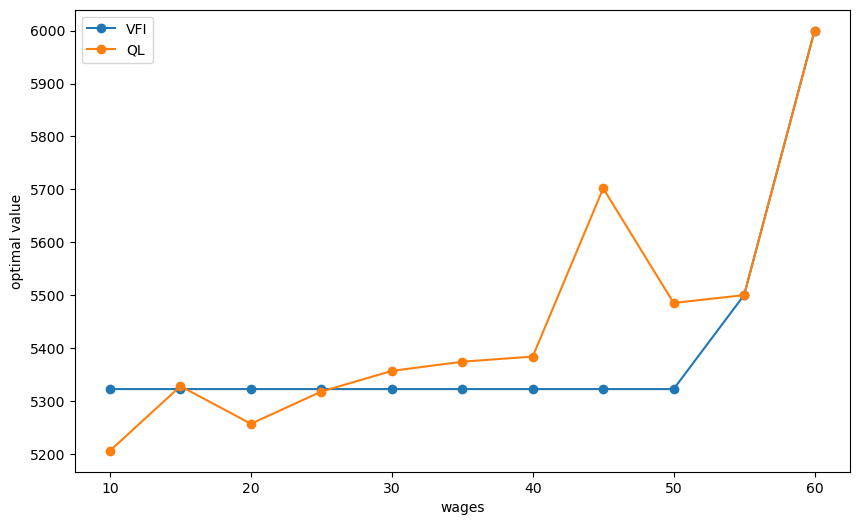

In [11]:
# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, valfunc_VFI, '-o', label='VFI')
ax.plot(w_default, valfunc_qlr, '-o', label='QL')
ax.set_xlabel('wages')
ax.set_ylabel('optimal value')
ax.legend()

plt.show()

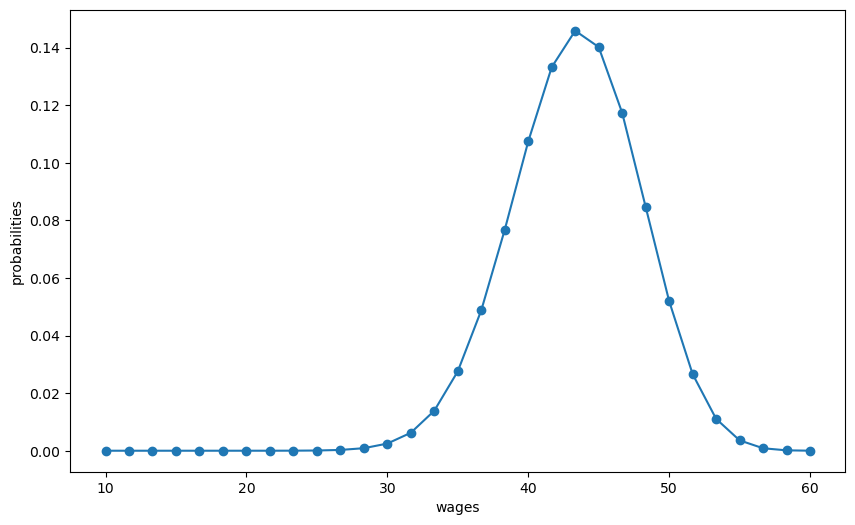

In [12]:
n, a, b = 30, 200, 100                        # default parameters
q_new = BetaBinomial(n, a, b).pdf()           # default choice of q

w_min, w_max = 10, 60
w_new = np.linspace(w_min, w_max, n+1)


# plot distribution of wage offer
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_new, q_new, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

# VFI
mcm = McCallModel(w=w_new, q=q_new)
valfunc_VFI, flag = mcm.VFI()

In [13]:
mcm = McCallModel(w=w_new, q=q_new)
valfunc_VFI, flag = mcm.VFI()
valfunc_VFI

array([4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       5000.        , 5166.66666667, 5333.33333333, 5500.        ,
       5666.66666667, 5833.33333333, 6000.        ])

In [14]:
def plot_epochs(epochs_to_plot, quit_allowed=1):
    "Plot value function implied by outcomes of an increasing number of epochs."
    qlmc_new = Qlearning_McCall(w=w_new, q=q_new, quit_allowed=quit_allowed)
    qtable = np.zeros((len(w_new),2))
    epochs_to_plot = np.asarray(epochs_to_plot)
    # plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(w_new, valfunc_VFI, '-o', label='VFI')

    max_epochs = np.max(epochs_to_plot)
    # iterate on epoch numbers
    for n in range(max_epochs + 1):
        if n%(max_epochs/10)==0:
            print(f"Progress: EPOCHs = {n}")
        if n in epochs_to_plot:
            valfunc_qlr = valfunc_from_qtable(qtable)
            error = compute_error(valfunc_qlr, valfunc_VFI)

            ax.plot(w_new, valfunc_qlr, '-o', label=f'QL:epochs={n}, mean error={error}')


        new_qtable = qlmc_new.run_one_epoch(qtable)
        qtable = new_qtable

    ax.set_xlabel('wages')
    ax.set_ylabel('optimal value')
    ax.legend(loc='lower right')
    plt.show()

Progress: EPOCHs = 0
Progress: EPOCHs = 20000


Progress: EPOCHs = 40000
Progress: EPOCHs = 60000
Progress: EPOCHs = 80000
Progress: EPOCHs = 100000


Progress: EPOCHs = 120000
Progress: EPOCHs = 140000
Progress: EPOCHs = 160000


Progress: EPOCHs = 180000
Progress: EPOCHs = 200000


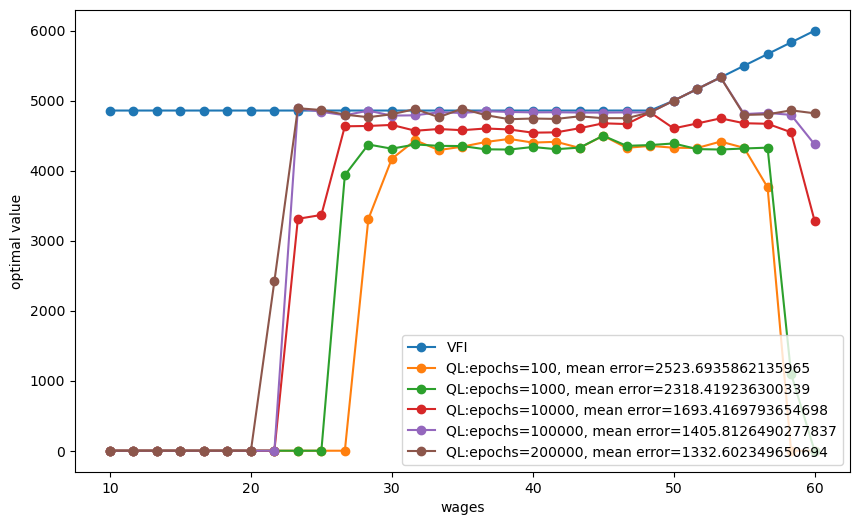

In [15]:
plot_epochs(epochs_to_plot=[100, 1000, 10000, 100000, 200000])

Progress: EPOCHs = 0


Progress: EPOCHs = 20000


Progress: EPOCHs = 40000
Progress: EPOCHs = 60000


Progress: EPOCHs = 80000


Progress: EPOCHs = 100000
Progress: EPOCHs = 120000


Progress: EPOCHs = 140000
Progress: EPOCHs = 160000


Progress: EPOCHs = 180000
Progress: EPOCHs = 200000


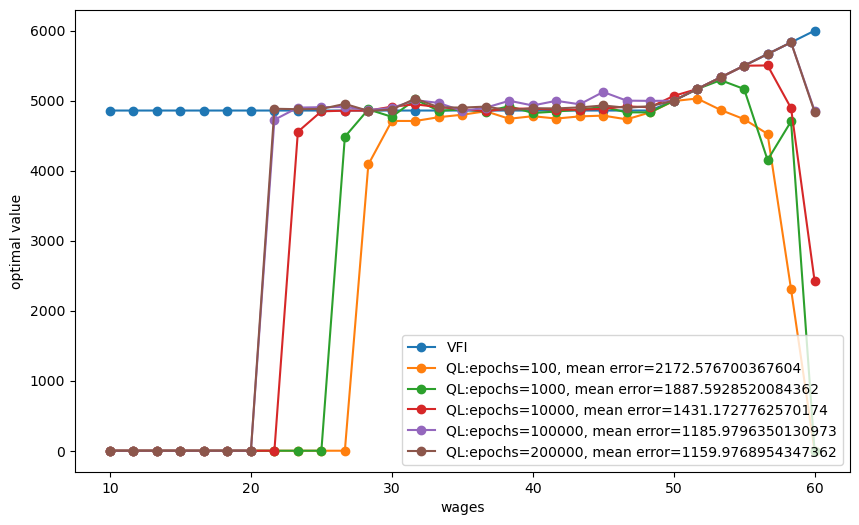

In [16]:
plot_epochs(epochs_to_plot=[100, 1000, 10000, 100000, 200000], quit_allowed=0)